# CycleGAN图像风格迁移互换

> 本案例运行需要较大内存，建议在Ascend/GPU上运行。


## 模型介绍

### 模型简介

CycleGAN(Cycle Generative Adversarial Network) 即循环对抗生成网络，来自论文 [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593) 。该模型实现了一种在没有配对示例的情况下学习将图像从源域 X 转换到目标域 Y 的方法。

该模型一个重要应用领域是域迁移(Domain Adaptation)，可以通俗地理解为图像风格迁移。其实在 CycleGAN 之前，就已经有了域迁移模型，比如 Pix2Pix ，但是 Pix2Pix 要求训练数据必须是成对的，而现实生活中，要找到两个域（画风）中成对出现的图片是相当困难的，因此 CycleGAN 诞生了，它只需要两种域的数据，而不需要他们有严格对应关系，是一种新的无监督的图像迁移网络。


### 模型结构

CycleGAN 网络本质上是由两个镜像对称的 GAN 网络组成，其结构如下图所示（图片来源于原论文）：

![CycleGAN](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/tutorials/source_zh_cn/generative/images/CycleGAN.png)


该模型一个很重要的部分就是损失函数，在所有损失里面循环一致损失(Cycle Consistency Loss)是最重要的。循环损失的计算过程如下图所示（图片来源于原论文）：

![Cycle Consistency Loss](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/tutorials/source_zh_cn/generative/images/CycleGAN_1.png)

循环损失捕捉了这样的直觉，即如果我们从一个域转换到另一个域，然后再转换回来，我们应该到达我们开始的地方。详细的训练过程见下文代码。

本任务旨在实现破损草图到目标线稿图之间的转化。

![sketch_lineart](https://openi.pcl.ac.cn/alcm/img/raw/commit/5881f56e772751e24a188c0bd0014e40db81c818/sketch_lineart.jpg)

## 数据集

本案例使用的数据集里面的图片为经图线稿图数据。图像被统一缩放为256×256像素大小，其中用于训练的线稿图片25654张、草图图片25654张，用于测试的线稿图片100张、草图图片116张。

这里对数据进行了随机裁剪、水平随机翻转和归一化的预处理.

### 数据集下载

使用 `download` 接口下载数据集，并将下载后的数据集自动解压到当前目录下。数据下载之前需要使用 `pip install download` 安装 `download` 包。


In [1]:
##直接使用大模型平台的mindspore 2.7.1+cann 8.3.rc1版本

In [1]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.7.1
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, dill, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: 


In [3]:
# 控制日志的级别, 0-DEBUG、1-INFO、2-WARNING、3-ERROR
%env GLOG_v=3

env: GLOG_v=3


In [2]:
import mindspore

#设置使用的设备
mindspore.set_device(device_target='Ascend')##gpu,cpu,Ascend
print(mindspore.get_context(attr_key='device_target'))

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Ascend


In [3]:
!git lfs install
# 下载数据集及预训练模型参数
!git clone https://modelers.cn/MindSpore-Lab/ckpt_dataset.git
# 解压数据集
!unzip -q ckpt_dataset/examples/localdata.zip -d ./localdata
# 解压预训练模型参数
!unzip -q ckpt_dataset/examples/checkpoints.zip -d ./ckpt

Git LFS initialized.
正克隆到 'ckpt_dataset'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0
接收对象中: 100% (9/9), 完成.
处理 delta 中: 100% (1/1), 完成.
过滤内容: 100% (2/2), 2.03 GiB | 33.47 MiB/s, 完成.


### 数据集加载


In [4]:
from __future__ import division
import math
import numpy as np

import os
import multiprocessing

import mindspore.dataset as de
import mindspore.dataset.vision as C

"""数据集分布式采样器"""
class DistributedSampler:
    """Distributed sampler."""
    def __init__(self, dataset_size, num_replicas=None, rank=None, shuffle=True):
        if num_replicas is None:
            print("***********Setting world_size to 1 since it is not passed in ******************")
            num_replicas = 1
        if rank is None:
            print("***********Setting rank to 0 since it is not passed in ******************")
            rank = 0
        self.dataset_size = dataset_size
        self.num_replicas = num_replicas
        self.rank = rank
        self.epoch = 0
        self.num_samples = int(math.ceil(dataset_size * 1.0 / self.num_replicas))
        self.total_size = self.num_samples * self.num_replicas
        self.shuffle = shuffle

    def __iter__(self):
        # deterministically shuffle based on epoch
        if self.shuffle:
            indices = np.random.RandomState(seed=self.epoch).permutation(self.dataset_size)
            # np.array type. number from 0 to len(dataset_size)-1, used as index of dataset
            indices = indices.tolist()
            self.epoch += 1
            # change to list type
        else:
            indices = list(range(self.dataset_size))

        # add extra samples to make it evenly divisible
        indices += indices[:(self.total_size - len(indices))]
        assert len(indices) == self.total_size

        # subsample
        indices = indices[self.rank:self.total_size:self.num_replicas]
        assert len(indices) == self.num_samples

        return iter(indices)

    def __len__(self):
        return self.num_samples

In [5]:
"""加载Cycle GAN 数据集."""

IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.tif', '.tiff']

def is_image_file(filename):
    """Judge whether it is a picture."""
    return any(filename.lower().endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset(dir_path, max_dataset_size=float("inf")):
    """Return image list in dir."""
    images = []
    assert os.path.isdir(dir_path), '%s is not a valid directory' % dir_path

    for root, _, fnames in sorted(os.walk(dir_path)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                images.append(path)
    return images[:min(max_dataset_size, len(images))]

class UnalignedDataset:
    """
    This dataset class can load unaligned/unpaired datasets.
    It requires two directories to host training images from domain A '/path/to/data/trainA'
    and from domain B '/path/to/data/trainB' respectively.
    You can train the model with the dataset flag '--dataroot /path/to/data'.
    Similarly, you need to prepare two directories:
    '/path/to/data/testA' and '/path/to/data/testB' during test time.
    Returns:
        Two domain image path list.
    """

    def __init__(self, dataroot, max_dataset_size=float("inf"), use_random=True):
        self.dir_A = os.path.join(dataroot, 'trainA')
        self.dir_B = os.path.join(dataroot, 'trainB')

        self.A_paths = sorted(make_dataset(self.dir_A, max_dataset_size))  # load images from '/path/to/data/trainA'
        self.B_paths = sorted(make_dataset(self.dir_B, max_dataset_size))  # load images from '/path/to/data/trainB'
        self.A_size = len(self.A_paths)  # get the size of dataset A
        self.B_size = len(self.B_paths)  # get the size of dataset B
        self.use_random = use_random

    def __getitem__(self, index):
        """Return a data point and its metadata information.

        Parameters:
            index (int)      -- a random integer for data indexing

        Returns a dictionary that contains A, B, A_paths and B_paths
            A (tensor)       -- an image in the input domain
            B (tensor)       -- its corresponding image in the target domain
            A_paths (str)    -- image paths
            B_paths (str)    -- image paths
        """
        index_B = index % self.B_size
        if index % max(self.A_size, self.B_size) == 0 and self.use_random:
            random.shuffle(self.A_paths)
            index_B = random.randint(0, self.B_size - 1)
        A_path = self.A_paths[index % self.A_size]
        B_path = self.B_paths[index_B]
        A_img = np.array(Image.open(A_path).convert('RGB'))
        B_img = np.array(Image.open(B_path).convert('RGB'))

        return A_img, B_img

    def __len__(self):
        """Return the total number of images in the dataset.
        """
        return max(self.A_size, self.B_size)

In [6]:
def create_dataset(dataroot,batch_size=1,use_random=True,device_num=1,rank=0,max_dataset_size=float("inf"),image_size=256):
    """
    Create dataset
    This dataset class can load images for train or test.
    Args:
        dataroot (str): Images root directory.
    Returns:
        RGB Image list.
    """
    shuffle = use_random
    cores = multiprocessing.cpu_count()
    num_parallel_workers = min(1, int(cores / device_num))

    mean = [0.5 * 255] * 3
    std = [0.5 * 255] * 3
    
    dataset = UnalignedDataset(dataroot, max_dataset_size=max_dataset_size, use_random=use_random)
    distributed_sampler = DistributedSampler(len(dataset), device_num, rank, shuffle=shuffle)
    ds = de.GeneratorDataset(dataset, column_names=["image_A", "image_B"],
                             sampler=distributed_sampler, num_parallel_workers=num_parallel_workers)
    if use_random:
        trans = [
            C.RandomResizedCrop(image_size, scale=(0.5, 1.0), ratio=(0.75, 1.333)),
            C.RandomHorizontalFlip(prob=0.5),
            C.Normalize(mean=mean, std=std),
            C.HWC2CHW()
        ]
    else:
        trans = [
            C.Resize((image_size, image_size)),
            C.Normalize(mean=mean, std=std),
            C.HWC2CHW()
        ]
    ds = ds.map(operations=trans, input_columns=["image_A"], num_parallel_workers=num_parallel_workers)
    ds = ds.map(operations=trans, input_columns=["image_B"], num_parallel_workers=num_parallel_workers)
    ds = ds.batch(batch_size, drop_remainder=True)
        
    return ds

In [7]:
#根据设备情况调整训练参数

dataroot = "./localdata"
batch_size = 12
device_num = 1
rank = 0
use_random = True
max_dataset_size = 24000
image_size = 256

cyclegan_ds = create_dataset(dataroot=dataroot,max_dataset_size=max_dataset_size,batch_size=batch_size,device_num=device_num,rank = rank,use_random=use_random,image_size=image_size)
datasize = cyclegan_ds.get_dataset_size()
print("Datasize: ", datasize)

Datasize:  2000


### 可视化

通过 `create_dict_iterator` 函数将数据转换成字典迭代器，然后使用 `matplotlib` 模块可视化部分训练数据。


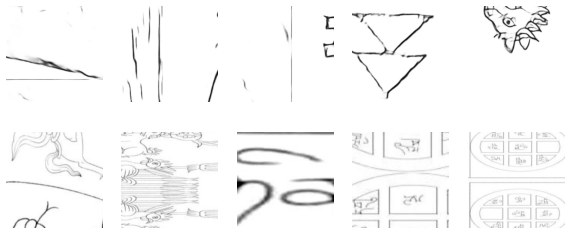

In [8]:
"""图片展示"""
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5), dpi=60)

for i, data in enumerate(cyclegan_ds.create_dict_iterator()):
    if i < 5:
        show_images_a = data["image_A"]
        show_images_b = data["image_B"]
        show_images_a = (show_images_a.asnumpy()[0]+1)/2  # 转换为NumPy数组并去除多余的维度
        show_images_b = (show_images_b.asnumpy()[0]+1)/2 # 转换为NumPy数组并去除多余的维度

        # 确保通道顺序正确（假设从RGB转换为BGR）
        show_images_a = show_images_a.transpose((1, 2, 0))  # 将通道维度移动到最后
        show_images_b = show_images_b.transpose((1, 2, 0))  # 将通道维度移动到最后
        show_images_a = show_images_a[..., ::-1]  # 反转通道顺序（从RGB到BGR）
        show_images_b = show_images_b[..., ::-1]  # 反转通道顺序（从RGB到BGR）

        plt.subplot(2, 5, i+1)
        plt.imshow(show_images_a)
        plt.axis("off")

        plt.subplot(2, 5, i+6)
        plt.imshow(show_images_b)
        plt.axis("off")
    else:
        break
plt.show()

## 构建生成器

本案例生成器的模型结构参考的 ResNet 模型的结构，参考原论文，对于128×128大小的输入图片采用6个残差块相连，图片大小为256×256以上的需要采用9个残差块相连，所以本文网络有9个残差块相连，超参数 `n_layers` 参数控制残差块数。

生成器的结构如下所示：

![CycleGAN Generator](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/tutorials/source_zh_cn/generative/images/CycleGAN_2.jpg)

具体的模型结构请参照下文代码：


In [9]:
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore.common.initializer import Normal

weight_init = Normal(sigma=0.02)

class ConvNormReLU(nn.Cell):
    def __init__(self, input_channel, out_planes, kernel_size=4, stride=2, alpha=0.2, norm_mode='instance',
                 pad_mode='CONSTANT', use_relu=True, padding=None, transpose=False):
        super(ConvNormReLU, self).__init__()
        norm = nn.BatchNorm2d(out_planes)
        if norm_mode == 'instance':
            norm = nn.BatchNorm2d(out_planes, affine=False)
        has_bias = (norm_mode == 'instance')
        if padding is None:
            padding = (kernel_size - 1) // 2
        if pad_mode == 'CONSTANT':
            if transpose:
                conv = nn.Conv2dTranspose(input_channel, out_planes, kernel_size, stride, pad_mode='same',
                                          has_bias=has_bias, weight_init=weight_init)
            else:
                conv = nn.Conv2d(input_channel, out_planes, kernel_size, stride, pad_mode='pad',
                                 has_bias=has_bias, padding=padding, weight_init=weight_init)
            layers = [conv, norm]
        else:
            paddings = ((0, 0), (0, 0), (padding, padding), (padding, padding))
            pad = nn.Pad(paddings=paddings, mode=pad_mode)
            if transpose:
                conv = nn.Conv2dTranspose(input_channel, out_planes, kernel_size, stride, pad_mode='pad',
                                          has_bias=has_bias, weight_init=weight_init)
            else:
                conv = nn.Conv2d(input_channel, out_planes, kernel_size, stride, pad_mode='pad',
                                 has_bias=has_bias, weight_init=weight_init)
            layers = [pad, conv, norm]
        if use_relu:
            relu = nn.ReLU()
            if alpha > 0:
                relu = nn.LeakyReLU(alpha)
            layers.append(relu)
        self.features = nn.SequentialCell(layers)

    def construct(self, x):
        output = self.features(x)
        return output


class ResidualBlock(nn.Cell):
    def __init__(self, dim, norm_mode='instance', dropout=False, pad_mode="CONSTANT"):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvNormReLU(dim, dim, 3, 1, 0, norm_mode, pad_mode)
        self.conv2 = ConvNormReLU(dim, dim, 3, 1, 0, norm_mode, pad_mode, use_relu=False)
        self.dropout = dropout
        if dropout:
            self.dropout = nn.Dropout(p=0.5)

    def construct(self, x):
        out = self.conv1(x)
        if self.dropout:
            out = self.dropout(out)
        out = self.conv2(out)
        return x + out


class ResNetGenerator(nn.Cell):
    def __init__(self, input_channel=3, output_channel=64, n_layers=9, alpha=0.2, norm_mode='instance', dropout=False,
                 pad_mode="CONSTANT"):
        super(ResNetGenerator, self).__init__()
        self.conv_in = ConvNormReLU(input_channel, output_channel, 7, 1, alpha, norm_mode, pad_mode=pad_mode)
        self.down_1 = ConvNormReLU(output_channel, output_channel * 2, 3, 2, alpha, norm_mode)
        self.down_2 = ConvNormReLU(output_channel * 2, output_channel * 4, 3, 2, alpha, norm_mode)
        layers = [ResidualBlock(output_channel * 4, norm_mode, dropout=dropout, pad_mode=pad_mode)] * n_layers
        self.residuals = nn.SequentialCell(layers)
        self.up_2 = ConvNormReLU(output_channel * 4, output_channel * 2, 3, 2, alpha, norm_mode, transpose=True)
        self.up_1 = ConvNormReLU(output_channel * 2, output_channel, 3, 2, alpha, norm_mode, transpose=True)
        if pad_mode == "CONSTANT":
            self.conv_out = nn.Conv2d(output_channel, 3, kernel_size=7, stride=1, pad_mode='pad',
                                      padding=3, weight_init=weight_init)
        else:
            pad = nn.Pad(paddings=((0, 0), (0, 0), (3, 3), (3, 3)), mode=pad_mode)
            conv = nn.Conv2d(output_channel, 3, kernel_size=7, stride=1, pad_mode='pad', weight_init=weight_init)
            self.conv_out = nn.SequentialCell([pad, conv])

    def construct(self, x):
        x = self.conv_in(x)
        x = self.down_1(x)
        x = self.down_2(x)
        x = self.residuals(x)
        x = self.up_2(x)
        x = self.up_1(x)
        output = self.conv_out(x)
        return ops.tanh(output)

# 实例化生成器
net_rg_a = ResNetGenerator()
# net_rg_a.update_parameters_name('net_rg_a.')

net_rg_b = ResNetGenerator()
# net_rg_b.update_parameters_name('net_rg_b.')


## 构建判别器

判别器其实是一个二分类网络模型，输出判定该图像为真实图的概率。网络模型使用的是 Patch 大小为 70x70 的 PatchGANs 模型。通过一系列的 `Conv2d` 、 `BatchNorm2d` 和 `LeakyReLU` 层对其进行处理，最后通过 Sigmoid 激活函数得到最终概率。


In [10]:
# 定义判别器
class Discriminator(nn.Cell):
    def __init__(self, input_channel=3, output_channel=64, n_layers=3, alpha=0.2, norm_mode='instance'):
        super(Discriminator, self).__init__()
        kernel_size = 4
        layers = [nn.Conv2d(input_channel, output_channel, kernel_size, 2, pad_mode='pad', padding=1, weight_init=weight_init),
                  nn.LeakyReLU(alpha)]
        nf_mult = output_channel
        for i in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** i, 8) * output_channel
            layers.append(ConvNormReLU(nf_mult_prev, nf_mult, kernel_size, 2, alpha, norm_mode, padding=1))
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8) * output_channel
        layers.append(ConvNormReLU(nf_mult_prev, nf_mult, kernel_size, 1, alpha, norm_mode, padding=1))
        layers.append(nn.Conv2d(nf_mult, 1, kernel_size, 1, pad_mode='pad', padding=1, weight_init=weight_init))
        self.features = nn.SequentialCell(layers)

    def construct(self, x):
        output = self.features(x)
        return output

# 判别器初始化
net_d_a = Discriminator()
# net_d_a.update_parameters_name('net_d_a.')

net_d_b = Discriminator()
# net_d_b.update_parameters_name('net_d_b.')


## 优化器和损失函数

根据不同模型需要单独的设置优化器，这是训练过程决定的。

对生成器 $G$ 及其判别器 $D_{Y}$ ，目标损失函数定义为:

$$L_{GAN}(G,D_Y,X,Y)=E_{y-p_{data}(y)}[logD_Y(y)]+E_{x-p_{data}(x)}[log(1-D_Y(G(x)))]$$

其中 $G$ 试图生成看起来与 $Y$ 中的图像相似的图像 $G(x)$ ，而 $D_{Y}$ 的目标是区分翻译样本 $G(x)$ 和真实样本 $y$ ，生成器的目标是最小化这个损失函数以此来对抗判别器。即 $ min_{G} max_{D_{Y}}L_{GAN}(G,D_{Y} ,X,Y )$ 。

单独的对抗损失不能保证所学函数可以将单个输入映射到期望的输出，为了进一步减少可能的映射函数的空间，学习到的映射函数应该是周期一致的，例如对于 $X$ 的每个图像 $x$ ，图像转换周期应能够将 $x$ 带回原始图像，可以称之为正向循环一致性，即 $x→G(x)→F(G(x))\approx x$ 。对于 $Y$ ，类似的 $x→G(x)→F(G(x))\approx x$ 。可以理解采用了一个循环一致性损失来激励这种行为。

循环一致损失函数定义如下：

$$L_{cyc}(G,F)=E_{x-p_{data}(x)}[\Vert F(G(x))-x\Vert_{1}]+E_{y-p_{data}(y)}[\Vert G(F(y))-y\Vert_{1}]$$

循环一致损失能够保证重建图像 $F(G(x))$ 与输入图像 $x$ 紧密匹配。


In [11]:
# 构建生成器，判别器优化器
optimizer_rg_a = nn.Adam(net_rg_a.trainable_params(), learning_rate=0.0002, beta1=0.5)
optimizer_rg_b = nn.Adam(net_rg_b.trainable_params(), learning_rate=0.0002, beta1=0.5)

optimizer_d_a = nn.Adam(net_d_a.trainable_params(), learning_rate=0.0002, beta1=0.5)
optimizer_d_b = nn.Adam(net_d_b.trainable_params(), learning_rate=0.0002, beta1=0.5)

# GAN网络损失函数，这里最后一层不使用sigmoid函数
loss_fn = nn.MSELoss(reduction='mean')
l1_loss = nn.L1Loss("mean")

def gan_loss(predict, target):
    target = ops.ones_like(predict) * target
    loss = loss_fn(predict, target)
    return loss


## 前向计算

搭建模型前向计算损失的过程，过程如下代码。

为了减少模型振荡[1]，这里遵循 Shrivastava 等人的策略[2]，使用生成器生成图像的历史数据而不是生成器生成的最新图像数据来更新鉴别器。这里创建 `image_pool` 函数，保留了一个图像缓冲区，用于存储生成器生成前的50个图像。


In [12]:
import mindspore as ms

# 前向计算

def generator(img_a, img_b):
    fake_a = net_rg_b(img_b)
    fake_b = net_rg_a(img_a)
    rec_a = net_rg_b(fake_b)
    rec_b = net_rg_a(fake_a)
    identity_a = net_rg_b(img_a)
    identity_b = net_rg_a(img_b)
    return fake_a, fake_b, rec_a, rec_b, identity_a, identity_b

lambda_a = 10.0
lambda_b = 10.0
lambda_idt = 0.5

def generator_forward(img_a, img_b):
    true = Tensor(True, dtype.bool_)
    fake_a, fake_b, rec_a, rec_b, identity_a, identity_b = generator(img_a, img_b)
    loss_g_a = gan_loss(net_d_b(fake_b), true)
    loss_g_b = gan_loss(net_d_a(fake_a), true)
    loss_c_a = l1_loss(rec_a, img_a) * lambda_a
    loss_c_b = l1_loss(rec_b, img_b) * lambda_b
    loss_idt_a = l1_loss(identity_a, img_a) * lambda_a * lambda_idt
    loss_idt_b = l1_loss(identity_b, img_b) * lambda_b * lambda_idt
    loss_g = loss_g_a + loss_g_b + loss_c_a + loss_c_b + loss_idt_a + loss_idt_b
    return fake_a, fake_b, loss_g, loss_g_a, loss_g_b, loss_c_a, loss_c_b, loss_idt_a, loss_idt_b

def generator_forward_grad(img_a, img_b):
    _, _, loss_g, _, _, _, _, _, _ = generator_forward(img_a, img_b)
    return loss_g

def discriminator_forward(img_a, img_b, fake_a, fake_b):
    false = Tensor(False, dtype.bool_)
    true = Tensor(True, dtype.bool_)
    d_fake_a = net_d_a(fake_a)
    d_img_a = net_d_a(img_a)
    d_fake_b = net_d_b(fake_b)
    d_img_b = net_d_b(img_b)
    loss_d_a = gan_loss(d_fake_a, false) + gan_loss(d_img_a, true)
    loss_d_b = gan_loss(d_fake_b, false) + gan_loss(d_img_b, true)
    loss_d = (loss_d_a + loss_d_b) * 0.5
    return loss_d

def discriminator_forward_a(img_a, fake_a):
    false = Tensor(False, dtype.bool_)
    true = Tensor(True, dtype.bool_)
    d_fake_a = net_d_a(fake_a)
    d_img_a = net_d_a(img_a)
    loss_d_a = gan_loss(d_fake_a, false) + gan_loss(d_img_a, true)
    return loss_d_a

def discriminator_forward_b(img_b, fake_b):
    false = Tensor(False, dtype.bool_)
    true = Tensor(True, dtype.bool_)
    d_fake_b = net_d_b(fake_b)
    d_img_b = net_d_b(img_b)
    loss_d_b = gan_loss(d_fake_b, false) + gan_loss(d_img_b, true)
    return loss_d_b

# 保留了一个图像缓冲区，用来存储之前创建的50个图像
pool_size = 50
def image_pool(images):
    num_imgs = 0
    image1 = []
    if isinstance(images, Tensor):
        images = images.asnumpy()
    return_images = []
    for image in images:
        if num_imgs < pool_size:
            num_imgs = num_imgs + 1
            image1.append(image)
            return_images.append(image)
        else:
            if random.uniform(0, 1) > 0.5:
                random_id = random.randint(0, pool_size - 1)

                tmp = image1[random_id].copy()
                image1[random_id] = image
                return_images.append(tmp)

            else:
                return_images.append(image)
    output = Tensor(return_images, ms.float32)
    if output.ndim != 4:
        raise ValueError("img should be 4d, but get shape {}".format(output.shape))
    return output


## 计算梯度和反向传播

其中梯度计算也是分开不同的模型来进行的，详情见如下代码：

In [13]:
from mindspore import value_and_grad

# 实例化求梯度的方法
grad_g_a = value_and_grad(generator_forward_grad, None, net_rg_a.trainable_params())
grad_g_b = value_and_grad(generator_forward_grad, None, net_rg_b.trainable_params())

grad_d_a = value_and_grad(discriminator_forward_a, None, net_d_a.trainable_params())
grad_d_b = value_and_grad(discriminator_forward_b, None, net_d_b.trainable_params())

# 计算生成器的梯度，反向传播更新参数
def train_step_g(img_a, img_b):
    net_d_a.set_grad(False)
    net_d_b.set_grad(False)

    fake_a, fake_b, lg, lga, lgb, lca, lcb, lia, lib = generator_forward(img_a, img_b)

    _, grads_g_a = grad_g_a(img_a, img_b)
    _, grads_g_b = grad_g_b(img_a, img_b)
    optimizer_rg_a(grads_g_a)
    optimizer_rg_b(grads_g_b)

    return fake_a, fake_b, lg, lga, lgb, lca, lcb, lia, lib

# 计算判别器的梯度，反向传播更新参数
def train_step_d(img_a, img_b, fake_a, fake_b):
    net_d_a.set_grad(True)
    net_d_b.set_grad(True)

    loss_d_a, grads_d_a = grad_d_a(img_a, fake_a)
    loss_d_b, grads_d_b = grad_d_b(img_b, fake_b)

    loss_d = (loss_d_a + loss_d_b) * 0.5

    optimizer_d_a(grads_d_a)
    optimizer_d_b(grads_d_b)

    return loss_d


## 模型训练

训练分为两个主要部分：训练判别器和训练生成器，在前文的判别器损失函数中，论文采用了最小二乘损失代替负对数似然目标。

- 训练判别器：训练判别器的目的是最大程度地提高判别图像真伪的概率。按照论文的方法需要训练判别器来最小化 $E_{y-p_{data}(y)}[(D(y)-1)^2]$ ；

- 训练生成器：如 CycleGAN 论文所述，我们希望通过最小化 $E_{x-p_{data}(x)}[(D(G(x)-1)^2]$ 来训练生成器，以产生更好的虚假图像。

下面定义了生成器和判别器的训练过程：


In [14]:
%%time
import os
import time
import random
import numpy as np
from PIL import Image
from mindspore import Tensor, save_checkpoint
from mindspore import dtype
from mindspore import load_checkpoint, load_param_into_net

def load_ckpt(net, ckpt_dir):
    param_GA = load_checkpoint(ckpt_dir)
    load_param_into_net(net, param_GA)

epochs = 1
save_step_num = 200
save_checkpoint_epochs = 1
save_ckpt_dir = './train_ckpt_outputs/'
save_img_dir='./image_outputs/'
resume=True

if(resume):
    g_a_ckpt = './ckpt/G_A_120.ckpt'
    g_b_ckpt = './ckpt/G_B_120.ckpt'
    d_a_ckpt = './ckpt/D_A_120.ckpt'
    d_b_ckpt = './ckpt/D_B_120.ckpt'

    load_ckpt(net_rg_a, g_a_ckpt)
    load_ckpt(net_rg_b, g_b_ckpt)
    load_ckpt(net_d_a, d_a_ckpt)
    load_ckpt(net_d_b, d_b_ckpt)
    
print('Start training!')



def train_loop(epoch):
    g_loss = []
    d_loss = []
    start_time_e = time.time()
    for step, data in enumerate(cyclegan_ds.create_dict_iterator()):
        start_time_s = time.time()
        img_a = data["image_A"]
        img_b = data["image_B"]
        res_g = train_step_g(img_a, img_b)
        fake_a = res_g[0]
        fake_b = res_g[1]
        if step==0:
            os.makedirs(save_img_dir, exist_ok=True)
            img_a_pil=Image.fromarray((img_a[0] * 0.5 * 255 + 0.5 * 255).astype(np.uint8).transpose((1, 2, 0)).asnumpy())
            img_b_pil=Image.fromarray((img_b[0] * 0.5 * 255 + 0.5 * 255).astype(np.uint8).transpose((1, 2, 0)).asnumpy())
            fake_a_pil=Image.fromarray((fake_a[0] * 0.5 * 255 + 0.5 * 255).astype(np.uint8).transpose((1, 2, 0)).asnumpy())
            fake_b_pil=Image.fromarray((fake_b[0] * 0.5 * 255 + 0.5 * 255).astype(np.uint8).transpose((1, 2, 0)).asnumpy())

            img_a_pil.save(f"./{save_img_dir}/{epoch}_img_a.jpg")
            img_b_pil.save(f"./{save_img_dir}/{epoch}_img_b.jpg")
            fake_a_pil.save(f"./{save_img_dir}/{epoch}_fake_a.jpg")
            fake_b_pil.save(f"./{save_img_dir}/{epoch}_fake_b.jpg")
            
        res_d = train_step_d(img_a, img_b, image_pool(fake_a), image_pool(fake_b))
        loss_d = float(res_d.asnumpy())
        step_time = time.time() - start_time_s

        res = []
        for item in res_g[2:]:
            res.append(float(item.asnumpy()))
        g_loss.append(res[0])
        d_loss.append(loss_d)

        if step % save_step_num == 0:
            print(f"Epoch:[{int(epoch + 1):>3d}/{int(epochs):>3d}], "
                  f"step:[{int(step):>4d}/{int(datasize):>4d}], "
                  f"time:{step_time:>3f}s,\n"
                  f"loss_g:{res[0]:.2f}, loss_d:{loss_d:.2f}, "
                  f"loss_g_a: {res[1]:.2f}, loss_g_b: {res[2]:.2f}, "
                  f"loss_c_a: {res[3]:.2f}, loss_c_b: {res[4]:.2f}, "
                  f"loss_idt_a: {res[5]:.2f}, loss_idt_b: {res[6]:.2f}")

    epoch_cost = time.time() - start_time_e
    per_step_time = epoch_cost / datasize
    mean_loss_d, mean_loss_g = sum(d_loss) / datasize, sum(g_loss) / datasize

    print(f"Epoch:[{int(epoch + 1):>3d}/{int(epochs):>3d}], "
          f"epoch time:{epoch_cost:.2f}s, per step time:{per_step_time:.2f}, "
          f"mean_g_loss:{mean_loss_g:.2f}, mean_d_loss:{mean_loss_d :.2f}")

    if epoch % save_checkpoint_epochs == 0:
        os.makedirs(save_ckpt_dir, exist_ok=True)
        save_checkpoint(net_rg_a, os.path.join(save_ckpt_dir, f"g_a_{epoch}.ckpt"))
        save_checkpoint(net_rg_b, os.path.join(save_ckpt_dir, f"g_b_{epoch}.ckpt"))
        save_checkpoint(net_d_a, os.path.join(save_ckpt_dir, f"d_a_{epoch}.ckpt"))
        save_checkpoint(net_d_b, os.path.join(save_ckpt_dir, f"d_b_{epoch}.ckpt"))

            
for t in range(epochs):
    train_loop(t)
    

print('End of training!')

Start training!
...........Epoch:[  1/  1], step:[   0/2000], time:128.427090s,
loss_g:2.05, loss_d:0.56, loss_g_a: 0.45, loss_g_b: 0.30, loss_c_a: 0.56, loss_c_b: 0.26, loss_idt_a: 0.14, loss_idt_b: 0.35
Epoch:[  1/  1], step:[ 200/2000], time:1.242917s,
loss_g:2.18, loss_d:0.68, loss_g_a: 0.12, loss_g_b: 0.42, loss_c_a: 0.45, loss_c_b: 0.72, loss_idt_a: 0.19, loss_idt_b: 0.28
Epoch:[  1/  1], step:[ 400/2000], time:1.216758s,
loss_g:1.44, loss_d:0.53, loss_g_a: 0.23, loss_g_b: 0.42, loss_c_a: 0.26, loss_c_b: 0.27, loss_idt_a: 0.15, loss_idt_b: 0.11
Epoch:[  1/  1], step:[ 600/2000], time:1.204901s,
loss_g:1.27, loss_d:0.57, loss_g_a: 0.49, loss_g_b: 0.19, loss_c_a: 0.18, loss_c_b: 0.21, loss_idt_a: 0.10, loss_idt_b: 0.11
Epoch:[  1/  1], step:[ 800/2000], time:1.214835s,
loss_g:114.13, loss_d:102.93, loss_g_a: 83.59, loss_g_b: 0.20, loss_c_a: 1.76, loss_c_b: 18.87, loss_idt_a: 0.27, loss_idt_b: 9.43
Epoch:[  1/  1], step:[1000/2000], time:1.220641s,
loss_g:46.72, loss_d:49.42, loss_g

## 模型推理

下面我们通过加载生成器网络模型参数文件来对原图进行风格迁移，结果中第一行为原图，第二行为对应生成的结果图。配合边缘检测模型可以实现从原图提取线稿图的作用。

### 边缘检测Dexined模型

In [15]:
import os
import cv2
import numpy as np
import time

import mindspore as ms
from mindspore import nn, ops
from mindspore import dataset as ds
from mindspore.amp import auto_mixed_precision
from mindspore.common import initializer as init

In [16]:
"""DexiNed边缘检测数据集"""
class Test_Dataset():
    """自定义数据集"""

    def __init__(self, data_root, mean_bgr, image_size):
        self.data = []
        imgs_ = os.listdir(data_root)
        self.names = []
        self.filenames = []
        for img in imgs_:
            if img.endswith(".png") or img.endswith(".jpg"):
                dir = os.path.join(data_root, img)
                self.names.append(dir)
                self.filenames.append(img)
        self.mean_bgr = mean_bgr
        self.image_size = image_size

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        image = cv2.imread(self.names[idx], cv2.IMREAD_COLOR)
        im_shape = (image.shape[0], image.shape[1])
        image = self.transform(img=image)
        return image, self.filenames[idx], im_shape

    def transform(self, img):
        img = cv2.resize(img, (self.image_size, self.image_size))
        img = np.array(img, dtype=np.float32)
        img -= self.mean_bgr
        img = img.transpose((2, 0, 1))
        return img


In [17]:
"""DexiNed 网络结构"""

def weight_init(net):
    for name, param in net.parameters_and_names():
        if 'weight' in name:
            param.set_data(
                init.initializer(
                    init.XavierNormal(),
                    param.shape,
                    param.dtype))
        if 'bias' in name:
            param.set_data(init.initializer('zeros', param.shape, param.dtype))


class CoFusion(nn.Cell):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_ch, 64, kernel_size=3,
            stride=1, padding=1, has_bias=True,
            pad_mode="pad", weight_init=init.XavierNormal())
        self.conv2 = nn.Conv2d(
            64, 64, kernel_size=3,
            stride=1, padding=1, has_bias=True,
            pad_mode="pad", weight_init=init.XavierNormal())
        self.conv3 = nn.Conv2d(
            64, out_ch, kernel_size=3,
            stride=1, padding=1, has_bias=True,
            pad_mode="pad", weight_init=init.XavierNormal())
        self.relu = nn.ReLU()
        self.norm_layer1 = nn.GroupNorm(4, 64)
        self.norm_layer2 = nn.GroupNorm(4, 64)

    def construct(self, x):
        attn = self.relu(self.norm_layer1(self.conv1(x)))
        attn = self.relu(self.norm_layer2(self.conv2(attn)))
        attn = ops.softmax(self.conv3(attn), axis=1)

        return ((x * attn).sum(1)).expand_dims(1)


class _DenseLayer(nn.Cell):
    def __init__(self, input_features, out_features):
        super(_DenseLayer, self).__init__()

        self.conv1 = nn.Conv2d(
            input_features, out_features, kernel_size=3,
            stride=1, padding=2, pad_mode="pad",
            has_bias=True, weight_init=init.XavierNormal())
        self.norm1 = nn.BatchNorm2d(out_features)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            out_features, out_features, kernel_size=3,
            stride=1, pad_mode="pad", has_bias=True,
            weight_init=init.XavierNormal())
        self.norm2 = nn.BatchNorm2d(out_features)
        self.relu = ops.ReLU()

    def construct(self, x):
        x1, x2 = x
        x1 = self.conv1(self.relu(x1))
        x1 = self.norm1(x1)
        x1 = self.relu1(x1)
        x1 = self.conv2(x1)
        new_features = self.norm2(x1)
        return 0.5 * (new_features + x2), x2


class _DenseBlock(nn.Cell):
    def __init__(self, num_layers, input_features, out_features):
        super(_DenseBlock, self).__init__()
        self.denselayer1 = _DenseLayer(input_features, out_features)
        input_features = out_features
        self.denselayer2 = _DenseLayer(input_features, out_features)
        if num_layers == 3:
            self.denselayer3 = _DenseLayer(input_features, out_features)
            self.layers = nn.SequentialCell(
                [self.denselayer1, self.denselayer2, self.denselayer3])
        else:
            self.layers = nn.SequentialCell(
                [self.denselayer1, self.denselayer2])

    def construct(self, x):
        x = self.layers(x)
        return x


class UpConvBlock(nn.Cell):
    def __init__(self, in_features, up_scale):
        super(UpConvBlock, self).__init__()
        self.up_factor = 2
        self.constant_features = 16

        layers = self.make_deconv_layers(in_features, up_scale)

        assert layers is not None, layers
        self.features = nn.SequentialCell(*layers)

    def make_deconv_layers(self, in_features, up_scale):
        layers = []
        all_pads = [0, 0, 1, 3, 7]
        for i in range(up_scale):
            kernel_size = 2 ** up_scale
            pad = all_pads[up_scale]  # kernel_size-1
            out_features = self.compute_out_features(i, up_scale)
            layers.append(nn.Conv2d(
                in_features, out_features,
                1, has_bias=True))
            layers.append(nn.ReLU())
            layers.append(nn.Conv2dTranspose(
                out_features, out_features, kernel_size,
                stride=2, padding=pad, pad_mode="pad",
                has_bias=True, weight_init=init.XavierNormal()))
            in_features = out_features
        return layers

    def compute_out_features(self, idx, up_scale):
        return 1 if idx == up_scale - 1 else self.constant_features

    def construct(self, x):
        return self.features(x)


class SingleConvBlock(nn.Cell):
    def __init__(self, in_features, out_features, stride,
                 use_bs=True
                 ):
        super().__init__()
        self.use_bn = use_bs
        self.conv = nn.Conv2d(
            in_features,
            out_features,
            1,
            stride=stride,
            pad_mode="pad",
            has_bias=True,
            weight_init=init.XavierNormal())
        self.bn = nn.BatchNorm2d(out_features)

    def construct(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        return x


class DoubleConvBlock(nn.Cell):
    def __init__(self, in_features, mid_features,
                 out_features=None,
                 stride=1,
                 use_act=True):
        super(DoubleConvBlock, self).__init__()

        self.use_act = use_act
        if out_features is None:
            out_features = mid_features
        self.conv1 = nn.Conv2d(
            in_features,
            mid_features,
            3,
            padding=1,
            stride=stride,
            pad_mode="pad",
            has_bias=True,
            weight_init=init.XavierNormal())
        self.bn1 = nn.BatchNorm2d(mid_features)
        self.conv2 = nn.Conv2d(
            mid_features,
            out_features,
            3,
            padding=1,
            pad_mode="pad",
            has_bias=True,
            weight_init=init.XavierNormal())
        self.bn2 = nn.BatchNorm2d(out_features)
        self.relu = nn.ReLU()

    def construct(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.use_act:
            x = self.relu(x)
        return x


class maxpooling(nn.Cell):
    def __init__(self):
        super(maxpooling, self).__init__()
        self.pad = nn.Pad(((0,0),(0,0),(1,1),(1,1)), mode="SYMMETRIC")
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='valid')

    def construct(self, x):
        x = self.pad(x)
        x = self.maxpool(x)
        return x

In [18]:
class DexiNed(nn.Cell):

    def __init__(self):
        super(DexiNed, self).__init__()
        self.block_1 = DoubleConvBlock(3, 32, 64, stride=2,)
        self.block_2 = DoubleConvBlock(64, 128, use_act=False)
        self.dblock_3 = _DenseBlock(2, 128, 256)  # [128,256,100,100]
        self.dblock_4 = _DenseBlock(3, 256, 512)
        self.dblock_5 = _DenseBlock(3, 512, 512)
        self.dblock_6 = _DenseBlock(3, 512, 256)

        self.maxpool = maxpooling()

        self.side_1 = SingleConvBlock(64, 128, 2)
        self.side_2 = SingleConvBlock(128, 256, 2)
        self.side_3 = SingleConvBlock(256, 512, 2)
        self.side_4 = SingleConvBlock(512, 512, 1)
        self.side_5 = SingleConvBlock(512, 256, 1)  
        
        # right skip connections, figure in Journal paper
        self.pre_dense_2 = SingleConvBlock(128, 256, 2)
        self.pre_dense_3 = SingleConvBlock(128, 256, 1)
        self.pre_dense_4 = SingleConvBlock(256, 512, 1)
        self.pre_dense_5 = SingleConvBlock(512, 512, 1)
        self.pre_dense_6 = SingleConvBlock(512, 256, 1)

        self.up_block_1 = UpConvBlock(64, 1)
        self.up_block_2 = UpConvBlock(128, 1)
        self.up_block_3 = UpConvBlock(256, 2)
        self.up_block_4 = UpConvBlock(512, 3)
        self.up_block_5 = UpConvBlock(512, 4)
        self.up_block_6 = UpConvBlock(256, 4)
        self.block_cat = SingleConvBlock(6, 1, stride=1, use_bs=False)

    def slice(self, tensor, slice_shape):
        t_shape = tensor.shape
        height, width = slice_shape
        if t_shape[-1] != slice_shape[-1]:
            new_tensor = ops.interpolate(
                tensor,
                sizes=(height, width),
                mode='bilinear',
                coordinate_transformation_mode="half_pixel")
        else:
            new_tensor = tensor
        return new_tensor

    def construct(self, x):
        assert x.ndim == 4, x.shape

        # Block 1
        block_1 = self.block_1(x)
        block_1_side = self.side_1(block_1)

        # Block 2
        block_2 = self.block_2(block_1)
        block_2_down = self.maxpool(block_2)
        block_2_add = block_2_down + block_1_side
        block_2_side = self.side_2(block_2_add)
        # Block 3
        block_3_pre_dense = self.pre_dense_3(block_2_down)
        block_3, _ = self.dblock_3([block_2_add, block_3_pre_dense])
        block_3_down = self.maxpool(block_3)  # [128,256,50,50]
        block_3_add = block_3_down + block_2_side
        block_3_side = self.side_3(block_3_add)
        # Block 4
        block_2_resize_half = self.pre_dense_2(block_2_down)
        block_4_pre_dense = self.pre_dense_4(
            block_3_down + block_2_resize_half)
        block_4, _ = self.dblock_4([block_3_add, block_4_pre_dense])
        block_4_down = self.maxpool(block_4)
        block_4_add = block_4_down + block_3_side
        block_4_side = self.side_4(block_4_add)
        # Block 5
        block_5_pre_dense = self.pre_dense_5(
            block_4_down)  # block_5_pre_dense_512 +block_4_down
        block_5, _ = self.dblock_5([block_4_add, block_5_pre_dense])
        block_5_add = block_5 + block_4_side
        # Block 6
        block_6_pre_dense = self.pre_dense_6(block_5)
        block_6, _ = self.dblock_6([block_5_add, block_6_pre_dense])
        # upsampling blocks
        out_1 = self.up_block_1(block_1)
        out_2 = self.up_block_2(block_2)
        out_3 = self.up_block_3(block_3)
        out_4 = self.up_block_4(block_4)
        out_5 = self.up_block_5(block_5)
        out_6 = self.up_block_6(block_6)
        results = [out_1, out_2, out_3, out_4, out_5, out_6]
        # concatenate multiscale outputs
        op = ops.Concat(1)
        block_cat = op(results)

        block_cat = self.block_cat(block_cat)  # Bx1xHxW
        results.append(block_cat)
        return results

In [19]:
'''将输入图像规格化到指定范围'''
def image_normalization(img, img_min=0, img_max=255, epsilon=1e-12):
    img = np.float32(img)
    img = (img - np.min(img)) * (img_max - img_min) / \
        ((np.max(img) - np.min(img)) + epsilon) + img_min
    return img

In [20]:
'''对DexiNed模型的输出数据进行后处理'''
def fuse_DNoutput(img):
    edge_maps = []
    tensor = img
    for i in tensor:
        sigmoid = ops.Sigmoid()
        output = sigmoid(i).numpy()
        edge_maps.append(output)
    tensor = np.array(edge_maps)
    idx = 0
    tmp = tensor[:, idx, ...]
    tmp = np.squeeze(tmp)
    preds = []
    for i in range(tmp.shape[0]):
        tmp_img = tmp[i]
        tmp_img = np.uint8(image_normalization(tmp_img))
        tmp_img = cv2.bitwise_not(tmp_img)
        preds.append(tmp_img)
        if i == 6:
            fuse = tmp_img
            fuse = fuse.astype(np.uint8)
    idx += 1
    return fuse


In [21]:
"""DexiNed 检测."""

def test(imgs,dexined_ckpt):
    
    if not os.path.isfile(dexined_ckpt):
        raise FileNotFoundError(
            f"Checkpoint file not found: {dexined_ckpt}")
    print(f"DexiNed ckpt path : {dexined_ckpt}")
    # os.makedirs(dexined_output_dir, exist_ok=True)
    model = DexiNed()
    # model = auto_mixed_precision(model, 'O2')
    ms.load_checkpoint(dexined_ckpt, model)
    model.set_train(False)
    preds = []
    origin = []
    total_duration = []
    print('Start dexined testing....')
    for img in imgs.create_dict_iterator():
        filename = str(img["names"])[2:-2]
        # print(filename)
        # output_dir_f = os.path.join(dexined_output_dir, filename)
        image = img["data"]
        origin.append(filename)
        end = time.perf_counter()
        pred = model(image)
        img_h = img["img_shape"][0, 0]
        img_w = img["img_shape"][0, 1]
        pred = fuse_DNoutput(pred)
        dexi_img = cv2.resize(
            pred, (int(img_w.asnumpy()), int(img_h.asnumpy())))
        # cv2.imwrite("output.jpg", dexi_img)
        tmp_duration = time.perf_counter() - end
        total_duration.append(tmp_duration)
        preds.append(pred)
    total_duration_f = np.sum(np.array(total_duration))
    print("FPS: %f.4" % (len(total_duration) / total_duration_f))
    return preds,origin

DexiNed ckpt path : ./ckpt/dexined.ckpt
Start dexined testing....
.FPS: 0.870458.4


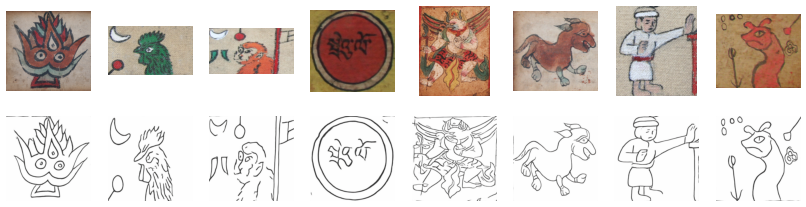

In [22]:
import os
import numpy as np
from PIL import Image
import mindspore.dataset as ds
import matplotlib.pyplot as plt
import mindspore.dataset.vision as vision
from mindspore.dataset import transforms
from mindspore import load_checkpoint, load_param_into_net

# 加载权重文件
def load_ckpt(net, ckpt_dir):
    param_GA = load_checkpoint(ckpt_dir)
    load_param_into_net(net, param_GA)

    
#模型参数地址
g_a_ckpt = './ckpt/G_A_120.ckpt'
dexined_ckpt = "./ckpt/dexined.ckpt"

#图片输入地址
img_path='./ckpt/jt'
#输出地址
save_path='./result'

load_ckpt(net_rg_a, g_a_ckpt)

os.makedirs(save_path, exist_ok=True)
# 图片推理
fig = plt.figure(figsize=(16, 4), dpi=64)
def eval_data(dir_path, net, a):
    my_dataset = Test_Dataset(
        dir_path, mean_bgr=[167.15, 146.07, 124.62], image_size=512)
    
    dataset = ds.GeneratorDataset(
        my_dataset, column_names=[
            "data", "names", "img_shape"])
    dataset = dataset.batch(1, drop_remainder=True)
    pres ,origin= test(dataset,dexined_ckpt)
    for i, data in enumerate(pres):
        img =ms.Tensor((np.array([data,data,data])/255-0.5)*2).unsqueeze(0)
        fake = net(img.to(ms.float32))
        
        fake = (fake[0] * 0.5 * 255 + 0.5 * 255).astype(np.uint8).transpose((1, 2, 0))
        img = (Image.open(os.path.join(img_path,origin[i])).convert('RGB'))

        fake_pil=Image.fromarray(fake.asnumpy())
        fake_pil.save(f"{save_path}/{i}.jpg")
        
        if i<8:
            fig.add_subplot(2, 8, min(i+1+a, 16))
            plt.axis("off")
            plt.imshow(np.array(img))

            fig.add_subplot(2, 8, min(i+9+a, 16))
            plt.axis("off")
            plt.imshow(fake.asnumpy())

eval_data(img_path,net_rg_a, 0)

plt.show()

## 参考

[1] I. Goodfellow. NIPS 2016 tutorial: Generative ad-versarial networks. arXiv preprint arXiv:1701.00160,2016. 2, 4, 5

[2] A. Shrivastava, T. Pfister, O. Tuzel, J. Susskind, W. Wang, R. Webb. Learning from simulated and unsupervised images through adversarial training. In CVPR, 2017. 3, 5, 6, 7